In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from DataPipe import DataPipe
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore", message="The behavior of DataFrame concatenation with empty or all-NA entries")

# First we run the Data Pipe Object to recieve the results of the Data Pipeline

In [2]:
# Initialize the Data class with the participants DataFrame
data_processor = DataPipe()
data_processor.get_subject_file_pairs()
data_processor.process_all_subjects()

[get_dataset_dir] Dataset found in /Users/mayerunterberg/nilearn_data/fsl


## Then the data is processed to run a linear regression and find the P values

Linear Regression Results with Significance Testing:
                                               Feature        R²   P-value
108  Temporal Fusiform Cortex, anterior division Vo...  0.281788  0.012803
35   Middle Temporal Gyrus, posterior division Volu...  0.113638  0.145112
34   Middle Temporal Gyrus, posterior division Volu...  0.113638  0.145112
3                                  Frontal Pole Change  0.091516  0.018331
44   Inferior Temporal Gyrus, posterior division Ch...  0.075937  0.071815
118                    Occipital Fusiform Gyrus Change  0.072249  0.111749
47   Inferior Temporal Gyrus, temporooccipital part...  0.062578  0.053391
41   Inferior Temporal Gyrus, anterior division Change  0.062224  0.078962
107                               Lingual Gyrus Change  0.056733  0.092797
127                   Parietal Opercular Cortex Change  0.051756  0.106982


/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_90727/3504278284.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


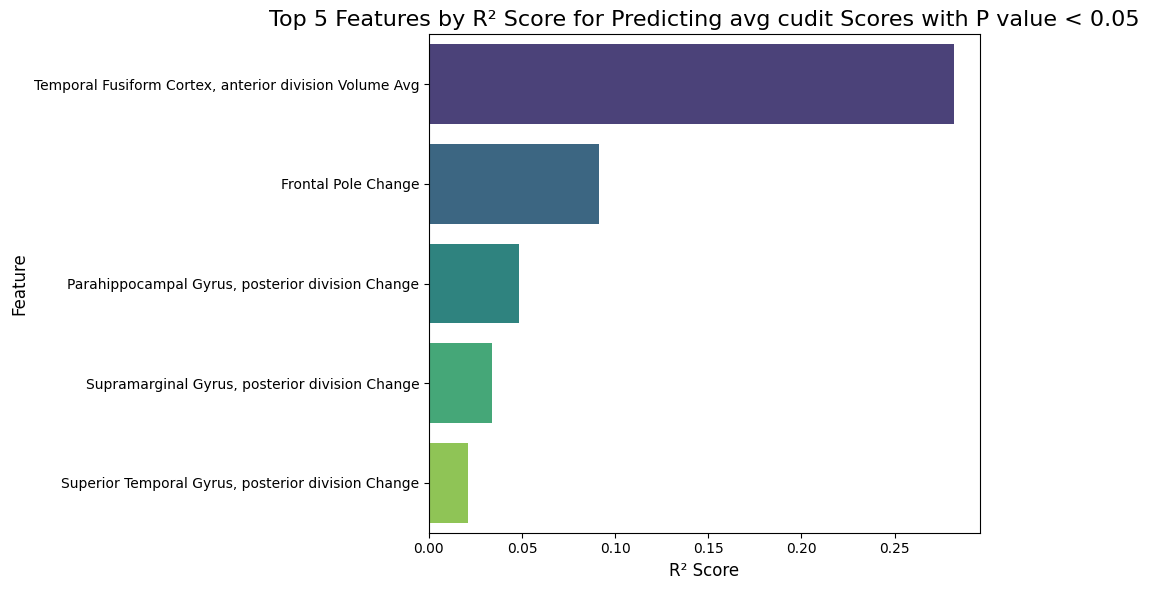

In [3]:
df = data_processor.participants_df
df['avg cudit'] = (df['cudit total baseline'] + df['cudit total follow-up']) / 2

# Drop irrelevant columns
df = df.drop(columns=['Baseline File Path', 'Followup File Path'])
columns_to_exclude = [
        'gender', 'avg cudit', 'cudit total baseline', 'cudit total follow-up',
        'audit total baseline', 'audit total follow-up', 'participant_id',
        'group', 'age at onset first CB use', 'age at onset frequent CB use','age at baseline',
        'Temporal Fusiform Cortex, posterior division Change', 'Inferior Temporal Gyrus, anterior division Volume Avg']

# Encode categorical columns and drop unnecessary columns
categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes
    
X = df_encoded.drop(columns=columns_to_exclude, errors='ignore')
y = df_encoded['avg cudit']

# Impute missing values with the mean
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
# Prepare a DataFrame to store results
results = pd.DataFrame(columns=['Feature', 'R²', 'P-value'])

# Perform linear regression for each feature with significance testing
for feature in X_imputed.columns:
    # Prepare single feature for regression
    X_feature = X_imputed[[feature]]
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.4, random_state=20)
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Predict and evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    # Use statsmodels for significance testing
    X_feature_with_const = sm.add_constant(X_feature)  # Add intercept
    ols_model = sm.OLS(y, X_feature_with_const).fit()
    if len(ols_model.pvalues) > 1:  # Ensure the p-value for the feature exists
        p_value = ols_model.pvalues.iloc[1]
    else:
        p_value = np.nan
    new_row = pd.DataFrame({'Feature': [feature], 'R²': [r2], 'P-value': [p_value]})
    # Check if the new_row is valid before concatenating
    if not new_row.isna().all(axis=None) and not new_row.empty:
        results = pd.concat([results, new_row], ignore_index=True)

# Sort the results by R² in descending order
results = results.sort_values(by='R²', ascending=False)
# Display the results
print("Linear Regression Results with Significance Testing:")
print(results.head(10))
# Save results to Excel if needed
results.to_excel('linear_regression_with_significance.xlsx', index=False)

# Assuming 'results' DataFrame is already loaded and sorted by R² in descending order
# Select the top 5 features by R²
top_5_results = results[results['P-value'] < 0.05].head(5)

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_5_results['R²'],
    y=top_5_results['Feature'],
    palette='viridis'
)

# Add title and labels
plt.title('Top 5 Features by R² Score for Predicting avg cudit Scores with P value < 0.05', fontsize=16)
plt.xlabel('R² Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [6]:
subject = 121
baseLine = 'output/registered_output_sub-' + str(subject) + '_ses-BL.nii.gz'
followUp = 'output/registered_output_sub-' + str(subject) + '_ses-FU.nii.gz'

baseLineBefore = 'Data/sub-' + str(subject) + '/ses-BL/anat/sub-' + str(subject) + '_ses-BL_T1w.nii.gz'
followUpBefore = 'Data/sub-' + str(subject) + '/ses-FU/anat/sub-' + str(subject) + '_ses-FU_T1w.nii.gz'

data_processor.display_brain_and_difference(baseLineBefore, followUpBefore)

ValueError: operands could not be broadcast together with shapes (256,256,170) (256,182,256) 